In [1]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape , Conv2D, MaxPooling2D, UpSampling2D , Cropping2D

In [2]:
from sklearn.model_selection import train_test_split
import random

# Set seed for reproducibility
def set_seed(seed_value):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)

SEED = 41
set_seed(SEED)

# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, filename)
                image = load_img(img_path, target_size=(128, 128))  # Resize image
                image_array = img_to_array(image)  # Convert to NumPy array
                image_array /= 255.0  # Normalize pixel values to [0, 1]
                images.append(image_array)
    images = np.array(images)
    return images

# Load images for x and y
x = []
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainA"))
x.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainA"))
x.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/input"))

y = []
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_scenes/trainB"))
y.extend(load_images_from_directory("/kaggle/input/image-enhancement-in-detecting-ocean-monument/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/underwater-imagenet-dataset/underwater_imagenet/trainB"))
y.extend(load_images_from_directory("/kaggle/input/lsui-large-scale-underwater-image-dataset/LSUI/GT"))

# Convert lists to numpy arrays
x_array = np.array(x)
y_array = np.array(y)

# Check the shapes of the arrays
print(f"x_array shape: {x_array.shape}")
print(f"y_array shape: {y_array.shape}")

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    x_array, y_array, test_size=0.2, random_state=SEED
)

# Check the shapes of the split arrays
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


x_array shape: (16292, 128, 128, 3)
y_array shape: (16292, 128, 128, 3)
x_train shape: (13033, 128, 128, 3)
x_test shape: (3259, 128, 128, 3)
y_train shape: (13033, 128, 128, 3)
y_test shape: (3259, 128, 128, 3)


Epoch 1/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 105s 108ms/step - loss: 0.1111 - mean_squared_error: 0.0220 - val_loss: 0.1103 - val_mean_squared_error: 0.0205
Epoch 2/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 73s 89ms/step - loss: 0.0880 - mean_squared_error: 0.0137 - val_loss: 0.0948 - val_mean_squared_error: 0.0146
Epoch 3/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - loss: 0.0831 - mean_squared_error: 0.0123 - val_loss: 0.0891 - val_mean_squared_error: 0.0129
Epoch 4/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - loss: 0.0799 - mean_squared_error: 0.0115 - val_loss: 0.0861 - val_mean_squared_error: 0.0121
Epoch 5/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - loss: 0.0778 - mean_squared_error: 0.0109 - val_loss: 0.0862 - val_mean_squared_error: 0.0121
Epoch 6/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - loss: 0.0763 - mean_squared_error: 0.0106 - val_loss: 0.0880 - val_mean_squared_error: 0.0125
Epoch 7/50
815/815 ━━━━━━━━━━━━━━━━━━━━ 72s 89ms/step - loss: 0.0751 - mean_squared_error: 0.0103 

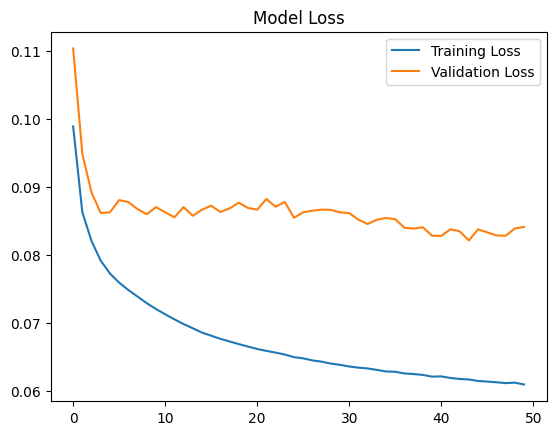

In [3]:
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping

# Define the input layer
inputs = layers.Input(shape=(128, 128, 3))

# Input Layer + Feature Extraction
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)  # Dropout after feature extraction

# Adding skip connections in the loop
for _ in range(3):
    skip_input = x  # Store input for the skip connection

    conv1 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(skip_input)
    conv1 = layers.BatchNormalization()(conv1)
    conv2 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(conv1)
    conv2 = layers.BatchNormalization()(conv2)

    # Add skip connection
    skip_output = layers.Add()([skip_input, conv2])
    skip_output = layers.Dropout(0.3)(skip_output)  # Apply dropout

    # Update x with skip_output
    x = skip_output

# Non-Local Attention (simulated with another Conv2D layer)
x = layers.Conv2D(128, (1, 1), padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout after attention layer

# Color Correction + Dehazing (Multi-scale features)
x = layers.Conv2D(128, (3, 3), dilation_rate=2, padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3, 3), dilation_rate=4, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout after dehazing layers

# Upsampling to match the target size (128x128)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu')(x)

# Output Reconstruction
outputs = layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=16,  # Define batch size here
    verbose=1
)

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [3]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("/kaggle/input/enhancenet/pytorch/default/1/enhancenet.h5")

# Check the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 128)    │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 128)    │              0 │ dropout[0][0],         │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64, 128)    │              0 │ dropout_1[0][0],       │
│                           │                        │                │ batch_normalization_3… │
├──────────────────────

 Total params: 1,502,469 (5.73 MB)

 Trainable params: 1,500,931 (5.73 MB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 2 (12.00 B)

102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step


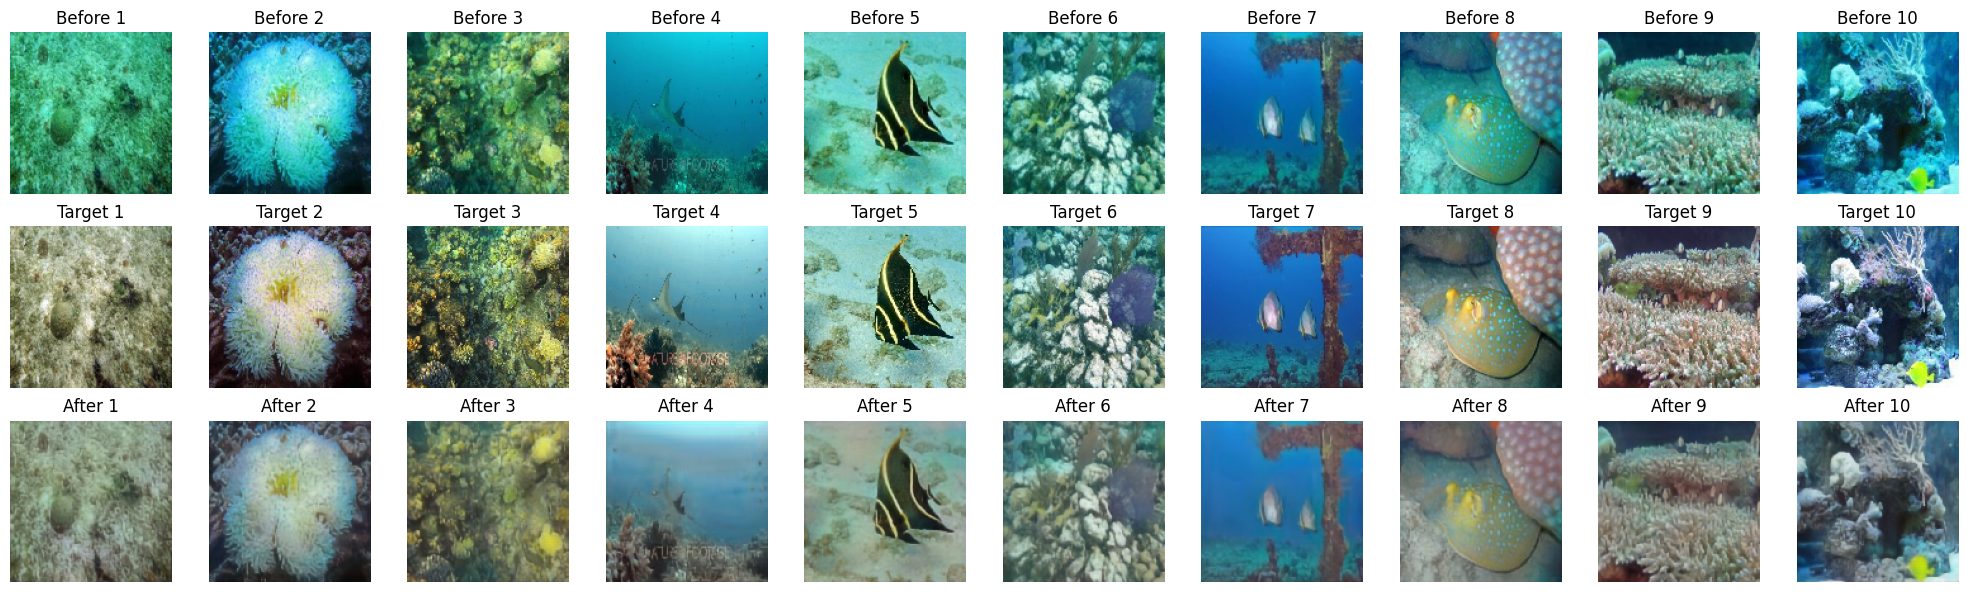

In [4]:
# Predict the enhanced images
y_pred = model.predict(x_test)

# Select 10 random images from the test set
indices = np.random.choice(len(x_test), 10, replace=False)

# Create a plot to display the images
fig, axes = plt.subplots(3, 10, figsize=(20, 6))

for i, idx in enumerate(indices):
    # Before enhancement (x_test)
    ax = axes[0, i]
    ax.imshow(x_test[idx])
    ax.axis('off')
    ax.set_title(f"Before {i+1}")

    # Target (y_test)
    ax = axes[1, i]
    ax.imshow(y_test[idx])
    ax.axis('off')
    ax.set_title(f"Target {i+1}")

    # After enhancement (predicted by the model)
    ax = axes[2, i]
    ax.imshow(y_pred[idx])
    ax.axis('off')
    ax.set_title(f"After {i+1}")

plt.tight_layout()
plt.show()


In [5]:
model.save("enhancenet.h5")  # Save in HDF5 format
